In [ ]:
!pip install wget

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import zipfile
import os
import wget
import glob
import time
import requests
from PIL import Image
from io import BytesIO

In [ ]:
class DatasetProcessor:
    def __init__(self, url, dataset_zip, dataset_dir):
        self.url = url
        self.dataset_zip = dataset_zip
        self.dataset_dir = dataset_dir

    def download_and_extract(self):
        """

        """
        wget.download(self.url, self.dataset_zip)
        with zipfile.ZipFile(self.dataset_zip, 'r') as zip_ref:
            zip_ref.extractall(self.dataset_dir)
        print("Dataset downloaded and extracted successfully.")

    def prepare_data_generators(self):
        base_dir = os.path.join(self.dataset_dir, 'zeronine')

        if not os.path.exists(base_dir):
            raise Exception(f"Base directory {base_dir} does not exist.")

        categories = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
        for category in categories:
            if len(glob.glob(f"{base_dir}/{category}/*")) == 0:
                raise Exception(f"No images found in category {category}.")

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,        # Small rotation, 10 degrees
            width_shift_range=0.1,    # Small shift, 10%
            height_shift_range=0.1,   # Small shift, 10%
            shear_range=0.1,          # Small shear
            zoom_range=0.1,           # Small zoom
            fill_mode='nearest',
            validation_split=0.2      # 20% for validation
        )

        self.train_generator = train_datagen.flow_from_directory(
            base_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='categorical',
            subset='training'  # Set as training data
        )
        self.validation_generator = train_datagen.flow_from_directory(
            base_dir,
            target_size=(150, 150),
            batch_size=32,
            class_mode='categorical',
            subset='validation'  # Set as validation data
        )
        print("Data generators prepared successfully.")
        return self.train_generator, self.validation_generator

In [ ]:
class ModelBuilder:
    def __init__(self):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])

    def compile_model(self):
        self.model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
        )
        print("Model compiled successfully.")

    def train_model(self, train_generator, validation_generator):
        start_time = time.time()
        self.history = self.model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=35,
            validation_data=validation_generator,
            validation_steps=len(validation_generator),
            verbose=2
        )
        end_time = time.time()
        total_time = end_time - start_time
        avg_time_per_epoch = total_time / 35

        print(f"Total training time   : {total_time:.3f} seconds ({total_time / 60:.3f} minutes)")
        print(f"Average time per epoch: {avg_time_per_epoch:.3f} seconds/epoch")
        print("Model trained successfully.")

    def evaluate_model(self):
        acc = self.history.history['accuracy'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        print(f"Training accuracy     : {acc:.5f}")
        print(f"Validation accuracy   : {val_acc:.5f}")
        assert val_acc >= 0.85, "Validation accuracy is below 85%"
        print("Model evaluation completed successfully.")

    def plot_training_history(self):
        # accuracy values
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # loss values
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
        print("Training history plotted successfully.")

    def save_model(self, file_path):
        self.model.save(file_path)
        print(f"Model saved to {file_path}")

    def show_model_structure(self):
        self.model.summary()
        # Optional: Plot the model
        tf.keras.utils.plot_model(self.model, to_file='model_structure.png', show_shapes=True)
        print("Model structure shown successfully.")

In [ ]:
class ImagePredictor:
    def __init__(self, model, class_labels):
        self.model = model
        self.class_labels = class_labels

    def predict_image(self):
        uploaded = files.upload()
        for fn in uploaded.keys():
            path = fn
            img = image.load_img(path, target_size=(150, 150))
            img_tensor = image.img_to_array(img)
            img_tensor = np.expand_dims(img_tensor, axis=0)
            img_tensor /= 255.
            prediction = self.model.predict(img_tensor)
            predicted_class = np.argmax(prediction, axis=1)
            predicted_label = self.class_labels[predicted_class[0]]

            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Predicted: {predicted_label}")
            plt.show()

            print(f"The uploaded image is a {predicted_label}")

In [ ]:
dataset_processor = DatasetProcessor(
    url='https://github.com/ridwaanhall/datasets/raw/main/zeronine.zip',
    dataset_zip='zeronine.zip',
    dataset_dir='zeronine'
)
dataset_processor.download_and_extract()

Dataset downloaded and extracted successfully.


In [ ]:
train_generator, validation_generator = dataset_processor.prepare_data_generators()

Found 6037 images belonging to 10 classes.
Found 1506 images belonging to 10 classes.
Data generators prepared successfully.


In [ ]:
model_builder = ModelBuilder()
model_builder.compile_model()

Model compiled successfully.


In [ ]:
model_builder.train_model(train_generator, validation_generator)

Epoch 1/35
189/189 - 51s - loss: 2.1793 - accuracy: 0.2196 - val_loss: 1.3131 - val_accuracy: 0.6109 - 51s/epoch - 270ms/step
Epoch 2/35
189/189 - 45s - loss: 1.2519 - accuracy: 0.5904 - val_loss: 0.7432 - val_accuracy: 0.8094 - 45s/epoch - 238ms/step
Epoch 3/35
189/189 - 44s - loss: 0.8584 - accuracy: 0.7285 - val_loss: 0.5243 - val_accuracy: 0.8533 - 44s/epoch - 233ms/step
Epoch 4/35
189/189 - 45s - loss: 0.6943 - accuracy: 0.7795 - val_loss: 0.4206 - val_accuracy: 0.8772 - 45s/epoch - 240ms/step
Epoch 5/35
189/189 - 44s - loss: 0.5610 - accuracy: 0.8266 - val_loss: 0.2706 - val_accuracy: 0.9256 - 44s/epoch - 232ms/step
Epoch 6/35
189/189 - 44s - loss: 0.4591 - accuracy: 0.8554 - val_loss: 0.2208 - val_accuracy: 0.9402 - 44s/epoch - 232ms/step
Epoch 7/35
189/189 - 46s - loss: 0.3802 - accuracy: 0.8836 - val_loss: 0.2239 - val_accuracy: 0.9389 - 46s/epoch - 242ms/step
Epoch 8/35
189/189 - 44s - loss: 0.3557 - accuracy: 0.8955 - val_loss: 0.1590 - val_accuracy: 0.9568 - 44s/epoch - 231

In [ ]:
model_builder.evaluate_model()

Training accuracy     : 0.96455
Validation accuracy   : 0.98141
Model evaluation completed successfully.


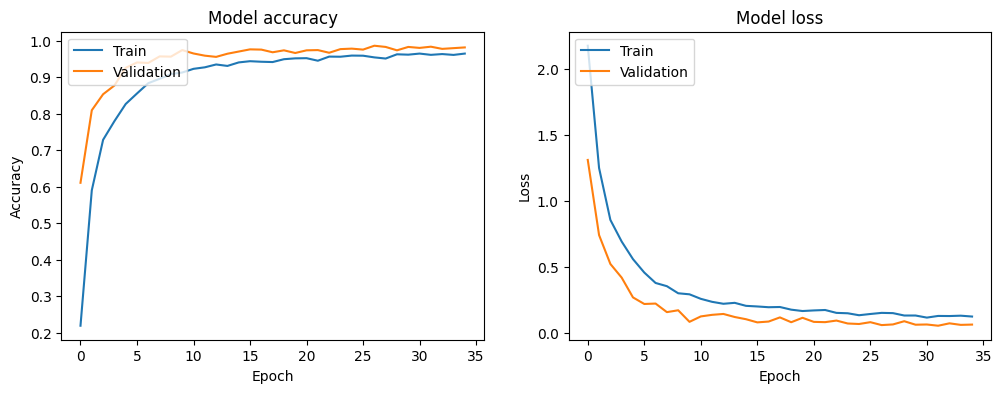

Training history plotted successfully.


In [ ]:
model_builder.plot_training_history()

In [ ]:
model_builder.show_model_structure()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [ ]:
model_builder.save_model('zeronine_project.h5')

Model saved to zeronine_project.h5


Saving 7_DataSet4_555.jpg to 7_DataSet4_555.jpg
1/1 [==============================] - 0s 18ms/step


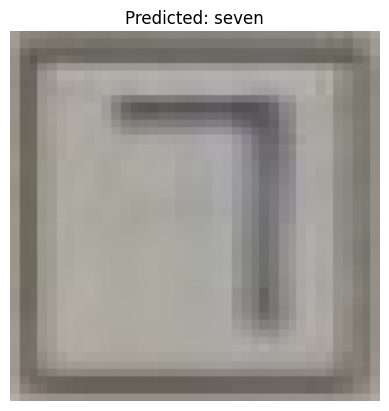

The uploaded image is a seven


In [ ]:
# Initialize image predictor
image_predictor = ImagePredictor(model=model_builder.model, class_labels=['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero'])
# Predict image
image_predictor.predict_image()